In [1]:
%env DRJIT_LIBLLVM_PATH /usr/lib/x86_64-linux-gnu/libLLVM-15.0.7.so.1
!echo $DRJIT_LIBLLVM_PATH

env: DRJIT_LIBLLVM_PATH=/usr/lib/x86_64-linux-gnu/libLLVM-15.0.7.so.1
/usr/lib/x86_64-linux-gnu/libLLVM-15.0.7.so.1


In [2]:
%%bash
ln -sf /usr/lib/x86_64-linux-gnu/libstdc++.so.6 ${CONDA_PREFIX}/lib/libstdc++.so.6
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/

In [3]:
import sys
sys.path.insert(0, '/home/jonathan/Documents/mi3-balance/build/python')

import drjit as dr
import mitsuba as mi
from drjit.auto import Float, UInt
import time

# mi.set_variant('cuda_ad_rgb')
mi.set_variant('llvm_ad_rgb')

In [4]:
from furnace_scene import make_scene, visualize_scene
import numpy as np

color_ref = [0.2, 0.25, 0.7]
scene = make_scene(color_ref)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1504576..3.3427212].


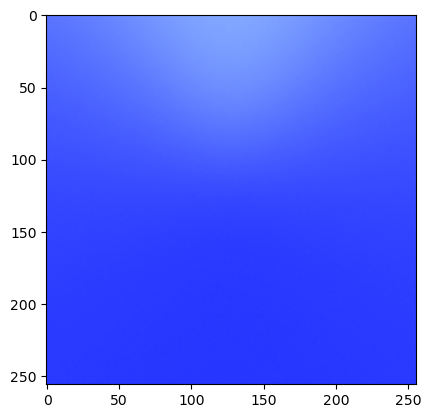

In [5]:
image = mi.render(scene)

import matplotlib.pyplot as plt
plt.imshow(image)

In [6]:
def define_BSDF(color_init = [0.5, 0.5, 0.5]):
    bsdf = mi.load_dict({
        "type": "diffuse",
        "reflectance": {
            "type": "rgb",
            "value": color_init
        }
    })
    param_key = "reflectance.value"
    return bsdf, param_key

In [7]:
from radiosity import SceneSurfaceSampler, RadianceCacheMITSUBA, compute_loss

NUM_WI_DIRECTIONS = 32 # 32
SAMPLES_PER_RAY_LI = 32 # 32
SAMPLES_PER_RAY_LO = 128 # 128
NUM_GEO_SAMPLES = 32 # 128

scene_sampler = SceneSurfaceSampler(scene)
radiance_cache = RadianceCacheMITSUBA(scene, 
                                      spp_per_wo=SAMPLES_PER_RAY_LO, 
                                      spp_per_wi=SAMPLES_PER_RAY_LI)


In [8]:
# Initialize BSDF to train
bsdf_train, key = define_BSDF()
params = mi.traverse(bsdf_train)
opt = mi.ad.Adam(lr=0.05)
dr.enable_grad(params[key])
opt[key] = params[key]
params.update(opt)

compute_loss(scene_sampler, radiance_cache, bsdf_train, 
        NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS)
losses = []
for it in range(200):
    time1 = time.time()

    # Evaluate the objective function for the current BSDF params
    loss = compute_loss(scene_sampler, radiance_cache, bsdf_train, 
        NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS)

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    # Post-process the optimized parameters to ensure legal color values.
    opt[key] = dr.clip(opt[key], 0.0, 1.0)

    # Update the scene state to the new optimized values
    params.update(opt)

    losses.append(loss.numpy())
    time2 = time.time()
    # print(f"Iteration {1+it:03d} [{time2 - time1:2f}]: Loss = {loss}, p = {opt[key]}")
    print(f"Iteration {1+it:03d} [{time2 - time1:2f}]: Loss = {loss}")

Iteration 001 [0.019763]: Loss = [0.347887]
Iteration 002 [0.019018]: Loss = [0.211056]
Iteration 003 [0.020333]: Loss = [0.111814]
Iteration 004 [0.020887]: Loss = [0.0492181]
Iteration 005 [0.018724]: Loss = [0.0196941]
Iteration 006 [0.021328]: Loss = [0.0159873]
Iteration 007 [0.018703]: Loss = [0.0275634]
Iteration 008 [0.021343]: Loss = [0.0434605]
Iteration 009 [0.018780]: Loss = [0.0557658]
Iteration 010 [0.018777]: Loss = [0.0609143]
Iteration 011 [0.018669]: Loss = [0.058815]
Iteration 012 [0.019296]: Loss = [0.0513819]
Iteration 013 [0.018882]: Loss = [0.0413195]
Iteration 014 [0.018610]: Loss = [0.0312685]
Iteration 015 [0.020655]: Loss = [0.023234]
Iteration 016 [0.020786]: Loss = [0.0182595]
Iteration 017 [0.018768]: Loss = [0.0163572]
Iteration 018 [0.018671]: Loss = [0.0167107]
Iteration 019 [0.021444]: Loss = [0.0180882]
Iteration 020 [0.018690]: Loss = [0.019314]
Iteration 021 [0.021210]: Loss = [0.0196183]
Iteration 022 [0.018713]: Loss = [0.0187666]
Iteration 023 [0

Reference albedo: [0.2, 0.25, 0.7]
Optimized albedo: [[0.198739, 0.248225, 0.691447]]


Text(0, 0.5, 'Loss')

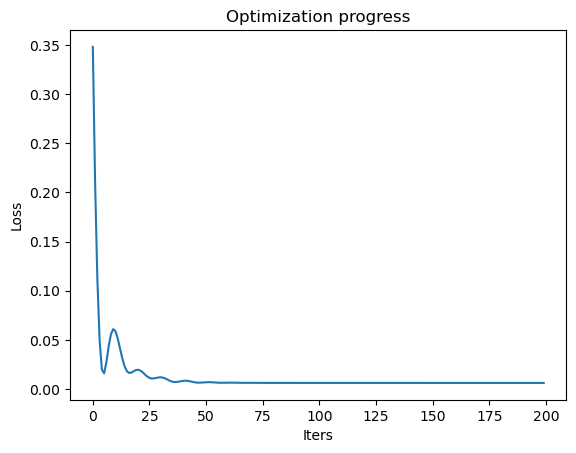

In [9]:
import matplotlib.pyplot as plt

print("Reference albedo:", color_ref)
print("Optimized albedo:", params[key])

plt.figure()
plt.title("Optimization progress")
plt.plot(np.array(losses))
plt.xlabel("Iters")
plt.ylabel("Loss")